<a id='1'></a>
# Import packages

In [1]:
from keras.layers import *
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import os
import cv2
import glob
import time
import numpy as np
from pathlib import PurePath, Path
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

import re
from PIL import Image
from utils import *

<a id='4'></a>
# Config

In [37]:
# Number of CPU cores
num_cpus = os.cpu_count()

# Face images storage path
faces_dir = './faces'
raw_faces_dir = os.path.join(faces_dir, 'raw_faces')
aligned_faces_dir = os.path.join(faces_dir, 'aligned_faces')
masks_faces_dir = os.path.join(faces_dir, 'binary_masks_eyes')
target_faces_dir = './target_faces'

# Preprocess configuration
prep_config = {}
prep_config['frame_rate'] = 25
prep_config['begin_time'] = 10
prep_config['end_time'] = 0
prep_config['min_resolution'] = 64
prep_config['extract_leader'] = True
prep_config['min_eyes_percent'] = 4.0
prep_config['target_search'] = {}
prep_config['target_search']['cosine_similarity'] = 0.40
prep_config['target_search']['euclidean_distance'] = 120
prep_config['target_search']['min_same_rate'] = 0.9


<a id='5a'></a>
# Utils

In [4]:
# List all face and raw face filenam,e
def list_all_faces():
    faces = []
    for file in os.listdir(raw_faces_dir):
        file_path = os.path.join(raw_faces_dir, file)
        if os.path.isfile(file_path):
            faces.append((file, file_path))
    return faces

# Remove the files of one face
def remove_face(face_filename):
    os.remove(os.path.join(raw_faces_dir, face_filename))
    os.remove(os.path.join(aligned_faces_dir, face_filename))
    os.remove(os.path.join(masks_faces_dir, face_filename))
    print('Removed face: %s' % face_filename)

# Get frame from filename
frame_pattern = re.compile(r'\d+')
def get_frame(face_filename):
    res = frame_pattern.findall(face_filename)
    assert len(res) == 2, 'Invalid face filename: %s' % face_filename
    return int(res[0])
    
# Frame to Time
def frame_to_time(frame):
    return int(frame / prep_config['frame_rate'])
    

<a id='5'></a>
# Filter by time

In [5]:
def filter_by_time(begin_time, end_time):
    all_faces = list_all_faces()
    for face_filename, raw_file_path in all_faces:
        frame = get_frame(face_filename)
        time = frame_to_time(frame)
        if begin_time > 0 and time < begin_time:
            remove_face(face_filename)
        if end_time > 0 and time > end_time:
            remove_face(face_filename)

filter_by_time(prep_config['begin_time'], prep_config['end_time'])

<a id='6'></a>
# Filter by resolution

In [6]:
def filter_by_resolution(min_resolution):
    all_faces = list_all_faces()
    for face_filename, raw_file_path in all_faces:
        if min_resolution > 0:
            image_size = Image.open(raw_file_path).size
            if image_size[0] < min_resolution or image_size[1] < min_resolution:
                remove_face(face_filename)
                
filter_by_resolution(prep_config['min_resolution'])            

<a id='7'></a>
# Extract leader
## leader means the biggest roler in every single frame.

In [7]:
def extract_frame_leader(one_frame_faces):
    if len(one_frame_faces) <= 1:
        return
    sizes = []
    for face_filename, raw_file_path in one_frame_faces:
        image_size = Image.open(raw_file_path).size
        sizes.append(image_size[0] * image_size[1])
    max_size_idx = sizes.index(max(sizes))
    idx = 0
    for face_filename, raw_file_path in one_frame_faces:
        if idx != max_size_idx:
            remove_face(face_filename)
        idx += 1        

def extract_leader():
    all_faces = list_all_faces()
    current_frame = 0
    one_frame_faces = []
    for face_filename, raw_file_path in all_faces:
        frame = get_frame(face_filename)
        if current_frame != frame:
            extract_frame_leader(one_frame_faces)
            one_frame_faces = []
            current_frame = frame
        one_frame_faces.append((face_filename, raw_file_path))
                    
if prep_config['extract_leader']:
    extract_leader()

In [8]:
# Loss function weights configuration
loss_weights = {}
loss_weights['w_D'] = 0.1 # Discriminator
loss_weights['w_recon'] = 1. # L1 reconstruction loss
loss_weights['w_edge'] = 0.1 # edge loss
loss_weights['w_eyes'] = 30. # reconstruction and edge loss on eyes area
loss_weights['w_pl'] = (0.01, 0.1, 0.3, 0.1) # perceptual loss (0.003, 0.03, 0.3, 0.3)

# Init. loss config.
loss_config = {}
loss_config["gan_training"] = "mixup_LSGAN" # "mixup_LSGAN" or "relativistic_avg_LSGAN"
loss_config['use_PL'] = False
loss_config["PL_before_activ"] = False
loss_config['use_mask_hinge_loss'] = False
loss_config['m_mask'] = 0.
loss_config['lr_factor'] = 1.
loss_config['use_cyclic_loss'] = False

<a id='mask'></a>
# Filter by eyes mask
## Remove the no eyes face images

In [9]:
def calc_eyes_percent(mask_file_path):
    image = Image.open(mask_file_path)
    total_px = image.size[0] * image.size[1]
    eyes_px = 0
    px = image.load()
    for x in range(image.size[0]):
        for y in range(image.size[1]):
            color_mean = sum(px[x, y]) / 3
            if color_mean > 128:
                eyes_px += 1
    return eyes_px * 100 / total_px

def filter_by_eyes_mask(min_eyes_percent):
    all_faces = list_all_faces()
    for face_filename, raw_file_path in all_faces:
        mask_file_path = os.path.join(masks_faces_dir, face_filename)
        eyes_percent = calc_eyes_percent(mask_file_path)
        if eyes_percent < min_eyes_percent:
            remove_face(face_filename)

if prep_config['min_eyes_percent'] > 0:
    filter_by_eyes_mask(prep_config['min_eyes_percent'])

<a id='manual'></a>
# Pickup more than 50 faces that belongs to the target person.
# Then copy these faces from aligned folder to ./target_faces

<a id='pickup'></a>
# Filter by target person
## Using VGGFace to predict and remove the persons not same as target faces.

In [12]:
from keras.engine import  Model
from keras.layers import Input
from keras.preprocessing import image as prep_image
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import *

# Convolution Features
vgg_features = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max


### We’ve represented input images as vectors. We will decide both pictures are same person or not based on comparing these vector representations. Now, we need to find the distance of these vectors. There are two common ways to find the distance of two vectors: cosine distance and euclidean distance. Cosine distance is equal to 1 minus cosine similarity. No matter which measurement we adapt, they all serve for finding similarities between vectors.

In [39]:
def find_cosine_similarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def find_euclidean_distance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

def predict_image(image_file_path):
    img = prep_image.load_img(image_file_path, target_size=(224, 224))
    x = prep_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x, version=1) # or version=2
    preds = vgg_features.predict(x)
    return preds

def compare_image_representations(r1, r2):
    cosine_similarity = find_cosine_similarity(r1, r2)
    euclidean_distance = find_euclidean_distance(r1, r2)
    if(cosine_similarity < prep_config['target_search']['cosine_similarity'] \
       or euclidean_distance < prep_config['target_search']['euclidean_distance']):
        return True
    else:
        return False
    
# Predict representations for all target faces
target_representations = []
for file in os.listdir(target_faces_dir):
    target_file_path = os.path.join(target_faces_dir, file)
    if os.path.isfile(target_file_path):
        preds = predict_image(target_file_path)
        target_representations.append(preds[0, :])

# Compare source faces with target faces
all_faces = list_all_faces()
for face_filename, raw_file_path in all_faces:
    aligned_file_path = os.path.join(aligned_faces_dir, face_filename)
    source_preds = predict_image(aligned_file_path)
    source_r = source_preds[0, :]
    same_count = 0
    for target_r in target_representations:
        if compare_image_representations(source_r, target_r):
            same_count += 1
    # Less then min_same_rate need remove
    same_rate = same_count / len(target_representations)
    if same_rate < prep_config['target_search']['min_same_rate']:
        remove_face(face_filename)
#         print(same_rate)
#         display_single_face_detection_result(faces_dir, face_filename)

Removed face: frame300face0.jpg
Removed face: frame4494face0.jpg
Removed face: frame4500face0.jpg
Removed face: frame6726face0.jpg
Removed face: frame6732face0.jpg
Removed face: frame6738face0.jpg
Removed face: frame6744face0.jpg
Removed face: frame6750face0.jpg
Removed face: frame6762face0.jpg
Removed face: frame6822face0.jpg
Removed face: frame6918face0.jpg
Removed face: frame7524face0.jpg
Removed face: frame7536face0.jpg
Removed face: frame8934face1.jpg
Removed face: frame8940face1.jpg
Removed face: frame8970face0.jpg
Removed face: frame8976face0.jpg
Removed face: frame8982face0.jpg
Removed face: frame9012face0.jpg
Removed face: frame11856face0.jpg
Removed face: frame11862face0.jpg
Removed face: frame11874face0.jpg
Removed face: frame11880face0.jpg
Removed face: frame11886face0.jpg
Removed face: frame11898face0.jpg
Removed face: frame11904face0.jpg
Removed face: frame11910face0.jpg
Removed face: frame11922face0.jpg
Removed face: frame11928face0.jpg
Removed face: frame11934face0.jpg


<a id='end'></a>
# Show some faces

Total faces: 917
frame276face0.jpg


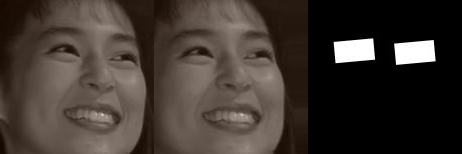

frame1854face0.jpg


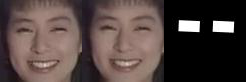

frame2166face0.jpg


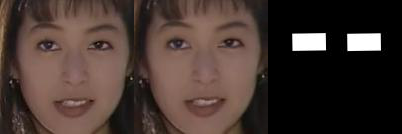

frame2568face0.jpg


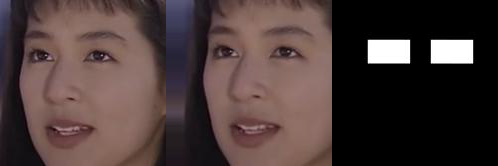

frame3678face0.jpg


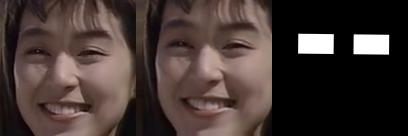

frame6738face0.jpg


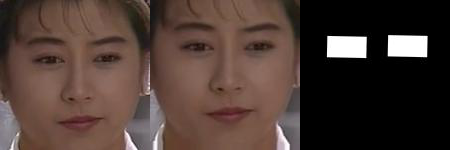

frame8988face0.jpg


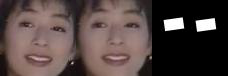

frame9408face0.jpg


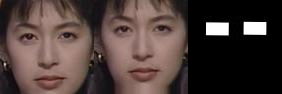

frame9534face0.jpg


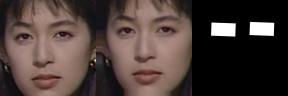

frame10482face0.jpg


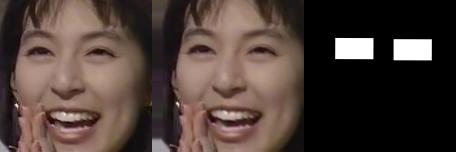

frame10644face0.jpg


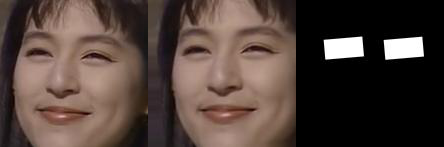

frame10770face0.jpg


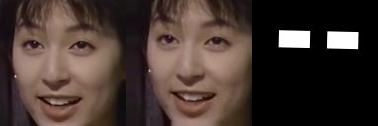

frame11928face0.jpg


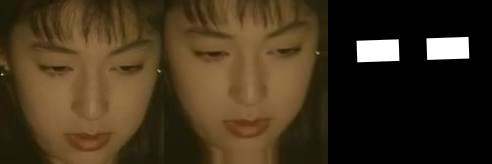

frame14970face0.jpg


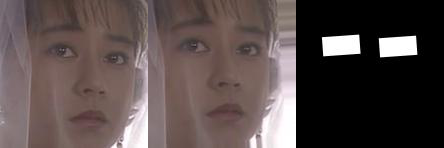

frame16044face0.jpg


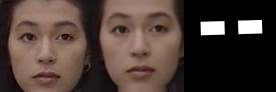

frame16296face0.jpg


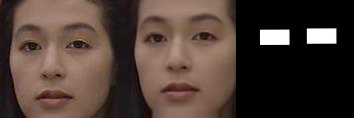

frame16572face0.jpg


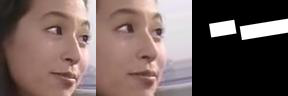

frame16812face0.jpg


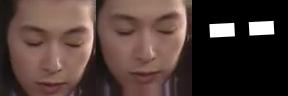

frame17064face0.jpg


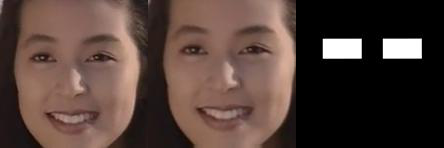

frame17190face0.jpg


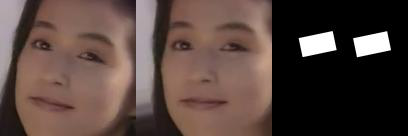

In [34]:
display_face_detection_result('./faces', 20)